In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Embedding Layer 
Add NAICS embedding to model.  Only add the baseline NAICS (not higher levels in the hierarchy).  Do not do any data manipulation, so unseen codes get mapped to an input that is not in training

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model

## Input Data

In [7]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

##### Features

In [10]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature - just bas
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [12]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [13]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 10), y:(446848,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


In [17]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [18]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Create, fit model

In [19]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-19 13:22:44.882692: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-19 13:22:44.882718: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-19 13:22:44.882723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-19 13:22:44.882754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 13:22:44.882770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 emb_naics_00 (Embedding)    (None, 1, 8)                 9360      ['input_naics_00[0][0]']      
                                                                                                  
 NAICS (Flatten)             (None, 8)                    0         ['emb_naics_00[0][0]']        
                                                                                                  
 input_numeric (InputLayer)  [(None, 10)]                 0         []                        

In [21]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [22]:
this_history = this_model.fit([X_train] + X_naics_train, y_train,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-19 13:22:45.448204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4625 - auc: 0.3378 - auc_1: 0.7002

2024-05-19 13:25:42.343260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 200s 14ms/step - loss: 0.4625 - auc: 0.3378 - auc_1: 0.7003 - val_loss: 0.4538 - val_auc: 0.3694 - val_auc_1: 0.7227
Epoch 2/20
13964/13964 [==============================] - 214s 15ms/step - loss: 0.4549 - auc: 0.3575 - auc_1: 0.7159 - val_loss: 0.4525 - val_auc: 0.3743 - val_auc_1: 0.7263
Epoch 3/20
13964/13964 [==============================] - 225s 16ms/step - loss: 0.4528 - auc: 0.3641 - auc_1: 0.7203 - val_loss: 0.4504 - val_auc: 0.3814 - val_auc_1: 0.7290
Epoch 4/20
13964/13964 [==============================] - 224s 16ms/step - loss: 0.4514 - auc: 0.3695 - auc_1: 0.7230 - val_loss: 0.4505 - val_auc: 0.3827 - val_auc_1: 0.7299
Epoch 5/20
13964/13964 [==============================] - 225s 16ms/step - loss: 0.4504 - auc: 0.3724 - auc_1: 0.7250 - val_loss: 0.4510 - val_auc: 0.3834 - val_auc_1: 0.7297
Epoch 6/20
13964/13964 [==============================] - 228s 16ms/step - loss: 0.4498 - auc: 0.3745 - auc_1: 0.7262 - val_loss: 0.4498

In [23]:
this_history_df = sbnn_model.process_history(this_history)

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_history.csv'))

<Axes: >

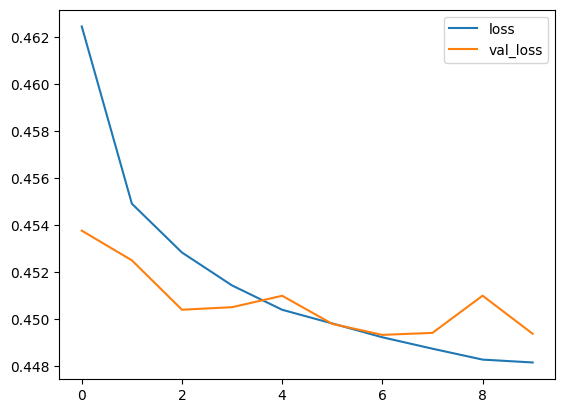

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

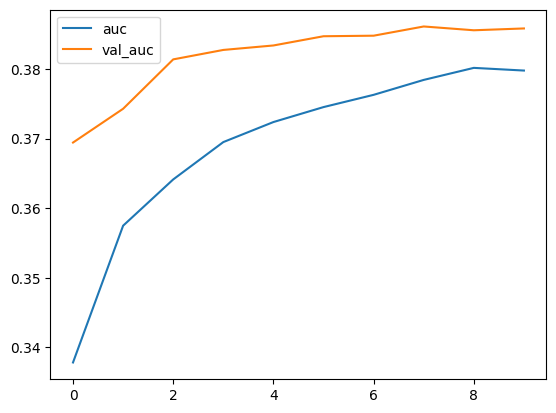

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

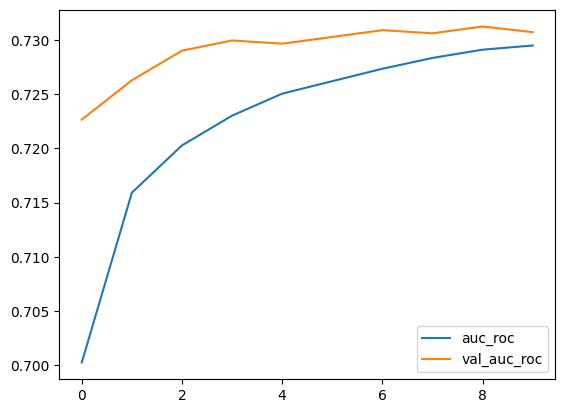

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('03_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [29]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [30]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])

   40/21735 [..............................] - ETA: 58s 

2024-05-19 14:00:06.231239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 59s 3ms/step


In [31]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [32]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.320754
target,0.320754,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [33]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [34]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [35]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.453711
11,0.22,0.452821
13,0.26,0.451935


In [36]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [37]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [38]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.568838
1    0.431162
Name: proportion, dtype: float64

In [39]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('03_DATA_predictions.parquet'))

## Metrics

In [40]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.614108,0.438016,0.310105,0.745530,0.360283,0.715891,NaN
1,train,0.662187,0.453711,0.337159,0.693418,0.392867,0.736439,NaN
2,val,0.660318,0.451612,0.336555,0.686201,0.385937,0.730732,NaN
0,test,0.658246,0.447250,0.333081,0.680505,0.379322,0.726497,0.0
1,test,0.540746,0.426159,0.283730,0.855721,0.346411,0.718357,1.0
